<a href="https://colab.research.google.com/github/Lcocks/DS6050-DeepLearning/blob/main/German_credit.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

https://colab.research.google.com/drive/1Z4h7a98YGhJ65L3_QsfEe0FOaZh8hTHT?usp=sharing

https://archive.ics.uci.edu/dataset/144/statlog+german+credit+data

In [66]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
"""
Part 1: Vanilla MLP Baseline for German Credit Risk Prediction
Dataset (UCI ML Repository):
- Name: Statlog (German Credit Data)
- Direct data file used here (space-separated):
  https://archive.ics.uci.edu/ml/machine-learning-databases/statlog/german/german.data
- Approx. size: 1,000 rows × 20 features + 1 label (the 21st column named `class`).
- Label encoding in the raw file: 1 = Good credit, 2 = Bad credit.
  We remap to: 0 = Good, 1 = Bad (binary classification with "Bad" as the positive class).

Caveats:
- This dataset mixes numeric and categorical (string-coded) features such as 'A11'.
  In this baseline, we use LabelEncoder per categorical column + StandardScaler on numerics.
  A stronger approach might use embeddings or target encoding for high-cardinality variables.

What you should expect:
- Because "Bad Credit" is the minority class (~30% in the full dataset), a vanilla model
  with a 0.5 threshold typically has *lower recall* on "Bad" (misses risky cases).
- Still, the AUC can look decent (e.g., ~0.78–0.80) because the model ranks many
  "Bad" cases higher than "Good" even if we choose a suboptimal decision threshold.

  1) Download the dataset if 'german.data' is not present.
  2) Train the MLP for a fixed number of epochs.
  3) Evaluate on a held-out test split and print AUC + classification report.
  4) Print an interpretation of the metrics and suggest next steps.

"""

# -------------------------
# 0. Imports
# -------------------------
import os
import urllib.request
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset, WeightedRandomSampler
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    roc_auc_score, classification_report, confusion_matrix, precision_recall_curve
)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
torch.manual_seed(42)
np.random.seed(42)

# -------------------------
# 2. Data Loading & Preprocessing
# -------------------------
# - If 'german.data' is missing, download from UCI.
# - Read as space-separated file with given column names.
# - Map label {1: Good, 2: Bad} -> {0: Good, 1: Bad}.
# - Identify numeric vs categorical columns.
# - Label-encode categoricals (per column) and standardize numerics (fit on train only).
# - Train/test split with stratification to maintain class ratio.
# - Return PyTorch tensors for model consumption.
def load_and_preprocess_data(file_path='german.data'):
    """Loads, preprocesses, and splits the German Credit dataset.

    Returns
    -------
    X_train_t : torch.FloatTensor, shape (n_train, d)
    X_test_t  : torch.FloatTensor, shape (n_test, d)
    y_train_t : torch.FloatTensor, shape (n_train,)
    y_test_t  : torch.FloatTensor, shape (n_test,)
    feature_names : list[str]
        Column names in the same order as the returned tensors.
    """
    url = 'https://archive.ics.uci.edu/ml/machine-learning-databases/statlog/german/german.data'
    if not os.path.exists(file_path):
        print("Downloading dataset from UCI...")
        urllib.request.urlretrieve(url, file_path)

    columns = [
        'checking_status', 'duration', 'credit_history', 'purpose', 'credit_amount',
        'savings_status', 'employment', 'installment_commitment', 'personal_status',
        'other_parties', 'residence_since', 'property_magnitude', 'age',
        'other_payment_plans', 'housing', 'existing_credits', 'job', 'num_dependents',
        'own_telephone', 'foreign_worker', 'class'
    ]
    # The raw file is single-space separated, no header
    df = pd.read_csv(file_path, sep=' ', header=None, names=columns)

    # Map label to {0: Good, 1: Bad} so that 1 means "Bad" (positive class)
    df['class'] = df['class'].map({1: 0, 2: 1}).astype(int)

    # Separate features and target
    X = df.drop(columns=['class']).copy()
    y = df['class'].values

    # Identify numeric vs categorical by pandas dtype
    numerical_cols = X.select_dtypes(include=np.number).columns.tolist()
    categorical_cols = X.select_dtypes(exclude=np.number).columns.tolist()

    # Label-encode categoricals *per column*
    # NOTE: This is a baseline choice. For production, consider embeddings/target encoding.
    for col in categorical_cols:
        X[col] = LabelEncoder().fit_transform(X[col])

    # Train-test split (80/20) with stratification
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, stratify=y, random_state=42
    )

    # Standardize numeric columns (fit on train only)
    scaler = StandardScaler()
    X_train[numerical_cols] = scaler.fit_transform(X_train[numerical_cols])
    X_test[numerical_cols] = scaler.transform(X_test[numerical_cols])

    feature_names = X.columns.tolist()  # preserve original order
    # Convert to tensors
    X_train_t = torch.FloatTensor(X_train[feature_names].values)
    X_test_t  = torch.FloatTensor(X_test[feature_names].values)
    y_train_t = torch.FloatTensor(y_train)
    y_test_t  = torch.FloatTensor(y_test)

    return X_train_t, X_test_t, y_train_t, y_test_t, feature_names


In [67]:
##  In class edits!  ## 

In [92]:
class TabularMLP(nn.Module):
    def __init__(self, input_dim, hidden_dims = [128, 64], dropout_rate = 0.3):
        super().__init__()
        layers = []
        prev_dim = input_dim
        for hidden_dim in hidden_dims:
            layers.append(nn.Linear(prev_dim, hidden_dim))
            layers.append(nn.BatchNorm1d(hidden_dim))
            #layers.append(nn.ReLU()) # first test used ReLU
            layers.append(nn.GELU()) # smooth activation function as well;  learning rate did not help changing it at first but now with GELU it does help.
            layers.append(nn.Dropout(dropout_rate))
            prev_dim = hidden_dim
        layers.append(nn.Linear(prev_dim, 1))
        self.network = nn.Sequential(*layers)
        
    def forward(self, x):
        return self.network(x).squeeze(-1) # shape i (batch,_)


    

In [93]:
def train(model, train_loader, criterion, optimizer, device, scheduler = None, epochs = 50): # in first case scheduler is not user then in main it is
    model.train()
    for epoch in range(epochs):
        epoch_loss = 0.0
        for xb, yb in train_loader:
            xb, yb = xb.to(device), yb.to(device)
            optimizer.zero_grad()
            logits = model(xb)
            loss = criterion(logits, yb)
            loss.backward()
            if scheduler is not None:
                scheduler.step()
            else:
                optimizer.step()
            optimizer.step()
            epoch_loss += loss.item() * xb.size(0)
        # good diea to print out epch loss at each level to check
                                    

In [94]:
def evaluate(model, data_loader, device):
    model.eval()
    all_probs = []
    all_labels = []
    with torch.no_grad():
        for xb, yb in data_loader:
            xb, yb = xb.to(device), yb.to(device)
            logits = model(xb)
            probs = torch.sigmoid(logits)
            all_probs.append(probs.cpu().numpy())
            all_labels.append(yb.cpu().numpy())
    return np.concatenate(all_probs), np.concatenate(all_labels)
            

In [95]:
def metrics_and_report(y_true, y_pred_probs, threshold = 0.5):  # threshold is the net of capture so we can use a function to calculate the optimal one like normal.
    y_pred = (y_pred_probs >= threshold).astype(int)
    auc = roc_auc_score(y_true, y_pred_probs)
    print(f"AUC: {auc:.3f}")
    print(classification_report(y_true, y_pred))
    print(confusion_matrix(y_true, y_pred))
    cm = confusion_matrix(y_true, y_pred)
    precision, recall, _ = precision_recall_curve(y_true, y_pred_probs)
    print(f"Precision: {precision.mean():.3f}")
    print(f"Recall: {recall.mean():.3f}")
    return auc, precision.mean(), recall.mean()


In [103]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(y_true, y_pred_probs, threshold=0.5):
    """Plots the confusion matrix."""
    y_pred = (y_pred_probs >= threshold).astype(int) # Convert probabilities to binary predictions
    cm = confusion_matrix(y_true, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.show()

In [106]:
def main():
    X_train, X_test, y_train, y_test, feature_names = load_and_preprocess_data()
    y_train_np = y_train.numpy().astype(int)
    class_counts = np.bincount(y_train_np)
    class_weights = 1. / class_counts
    class_weights = torch.tensor(class_weights, dtype=torch.float)
    sampler = WeightedRandomSampler(
        weights = class_weights[y_train_np],
        num_samples=len(y_train_np),
        replacement=True
    )
    
    train_dataset = TensorDataset(X_train, y_train)
    test_dataset = TensorDataset(X_test, y_test)
    train_loader = DataLoader(train_dataset, batch_size=64, sampler = sampler, shuffle=False)
    test_loader = DataLoader(test_dataset, batch_size = 64, shuffle=False)
    
    model = TabularMLP(input_dim=X_train.shape[1]).to(device)
    pos_weight = torch.tensor(class_counts[0]/class_counts[1], dtype = torch.float32, device = device)
    criterion = nn.BCEWithLogitsLoss(pos_weight=pos_weight)
    optimizer = optim.Adam(model.parameters(), lr=0.001) # Adam in not vanilla, it is using a fixed learning rate.
    #scheduler = optim.lr_scheduler.StepLR(optimizer, sep_size=5, gamma=0.5) is below
    scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max = 50, eta_min=0.0) #50 is the epochs, eta is the minimum point of the learning rate

    train(model, train_loader, criterion, optimizer, device, scheduler = scheduler, epochs=50)
    y_pred_probs, y_true = evaluate(model, test_loader, device)
    metrics = metrics_and_report(y_true, y_pred_probs)
    
    plot_confusion_matrix(y_true,y_pred_probs)

/home/epx8hh/.conda/envs/dsvenv/lib/python3.12/site-packages/torch/optim/lr_scheduler.py:182: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn(


AUC: 0.803
              precision    recall  f1-score   support

         0.0       0.92      0.54      0.68       140
         1.0       0.45      0.88      0.60        60

    accuracy                           0.65       200
   macro avg       0.68      0.71      0.64       200
weighted avg       0.78      0.65      0.66       200

[[76 64]
 [ 7 53]]
Precision: 0.524
Recall: 0.711


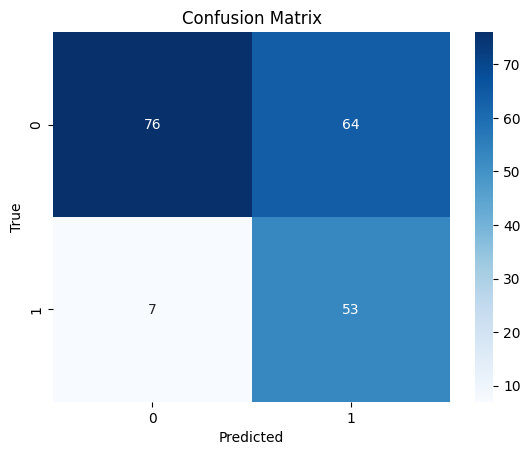

In [107]:
if __name__ == "__main__":
    main()

Good AUC telling us how much we are catching are zeros.

If the bad classes, ones that are struggling, getting low probabilities in the nueral network. And those that are good are getting zeros. Maybe we can penalize high probability. 
    We can change the threshold is the most direct change.
    Use loss to balance out classes, 
    Maybe we can oversample from the bad class.
    Maybe change the optimizer.

- By changing the WeightedRandomSampler, we improved the AUC but increased the TN's, but also equaled out the TP, FP more.